# **Detection of Surgical Instruments Using YOLO: An Enhanced Approach**

### 1). Using Faster RCNN as a baseline model

### Mounting the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchinfo

### Importing Libraries

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from albumentations import Compose as ACompose, HorizontalFlip, RandomBrightnessContrast, ShiftScaleRotate
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from albumentations import Compose, HorizontalFlip, RandomBrightnessContrast, ShiftScaleRotate
from albumentations.pytorch import ToTensorV2
from torchinfo import summary
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
#Checking the T4 GPU
!nvidia-smi


Mon Dec  9 20:54:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms

        # Initialize image_files with all image filenames
        self.image_files = [
            f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg'))
        ]

        # Filter image_files based on existence of corresponding label files
        self.image_files = [
            f for f in self.image_files if os.path.exists(
                os.path.join(label_dir, f.rsplit('.', 1)[0] + '.txt')
            )
        ]

        # Ensure that images with non-empty annotations are retained
        valid_images = []
        for img_file in self.image_files:
            label_file = os.path.join(label_dir, img_file.rsplit('.', 1)[0] + '.txt')
            with open(label_file, 'r') as file:
                if any(line.strip() for line in file.readlines()):  # Ensure label file is non-empty
                    valid_images.append(img_file)

        self.image_files = valid_images

        if not self.image_files:
            raise ValueError(f"No images with valid labels found in {image_dir} or {label_dir}")

        print(f"Total valid images with annotations: {len(self.image_files)}")  # Debugging

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(
            self.label_dir, self.image_files[idx].rsplit('.', 1)[0] + '.txt'
        )

        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        boxes = []
        labels = []
        with open(label_path, 'r') as file:
            for line in file.readlines():
                cls, xc, yc, bw, bh = map(float, line.strip().split())
                xmin = (xc - bw / 2) * w
                ymin = (yc - bh / 2) * h
                xmax = (xc + bw / 2) * w
                ymax = (yc + bh / 2) * h
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(int(cls) + 1)

        if len(boxes) == 0:
            print(f"No valid bounding boxes for image: {img_path}")  # Debugging

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        # Transform and normalize the image
        if self.transforms:
            augmented = self.transforms(image=img, bboxes=boxes, class_labels=labels)
            img = augmented["image"]
            target["boxes"] = torch.tensor(augmented["bboxes"], dtype=torch.float32)
            target["labels"] = torch.tensor(augmented["class_labels"], dtype=torch.int64)

        if isinstance(img, np.ndarray):  # Convert NumPy array to PyTorch tensor
            img = torch.tensor(img, dtype=torch.uint8).permute(2, 0, 1)

        if img.dtype != torch.float32:
            img = img.float() / 255.0

        return img, target




In [ ]:
def collate_fn(batch):
    batch = [b for b in batch if b[0] is not None and len(b[1]["boxes"]) > 0]
    return tuple(zip(*batch)) if batch else ([], [])


In [ ]:
def get_train_transforms():
    return ACompose(
        [
            HorizontalFlip(p=0.5),
            RandomBrightnessContrast(p=0.2),
            ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            ToTensorV2(),
        ],
        bbox_params={
            "format": "pascal_voc",
            "label_fields": ["class_labels"],
            "min_visibility": 0.0  # Temporarily disable filtering by visibility for debugging
        }
    )


In [ ]:
# IoU Calculation
def iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    inter_x1 = max(x1, x1_)
    inter_y1 = max(y1, y1_)
    inter_x2 = min(x2, x2_)
    inter_y2 = min(y2, y2_)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_ - x1_) * (y2_ - y1_)

    return inter_area / (box1_area + box2_area - inter_area)


# mAP Calculation
def calculate_map(model, dataloader, device, iou_threshold=0.5):
    model.eval()
    all_detections = []
    all_ground_truths = []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i in range(len(images)):
                pred_boxes = outputs[i]['boxes'].cpu().numpy()
                pred_scores = outputs[i]['scores'].cpu().numpy()
                pred_labels = outputs[i]['labels'].cpu().numpy()

                gt_boxes = targets[i]['boxes'].cpu().numpy()
                gt_labels = targets[i]['labels'].cpu().numpy()

                all_detections.append((pred_boxes, pred_scores, pred_labels))
                all_ground_truths.append((gt_boxes, gt_labels))

    aps = []
    for class_id in range(1, 9):  # Assuming 8 classes
        true_positives = []
        scores = []
        total_ground_truths = 0

        for det, gt in zip(all_detections, all_ground_truths):
            pred_boxes, pred_scores, pred_labels = det
            gt_boxes, gt_labels = gt

            pred_filter = pred_labels == class_id
            pred_boxes = pred_boxes[pred_filter]
            pred_scores = pred_scores[pred_filter]

            gt_filter = gt_labels == class_id
            gt_boxes = gt_boxes[gt_filter]
            total_ground_truths += len(gt_boxes)

            for pred_box, score in zip(pred_boxes, pred_scores):
                ious = [iou(pred_box, gt_box) for gt_box in gt_boxes]
                if ious and max(ious) >= iou_threshold:
                    true_positives.append(1)
                else:
                    true_positives.append(0)
                scores.append(score)

        sorted_indices = np.argsort(scores)[::-1]
        true_positives = np.array(true_positives)[sorted_indices]
        scores = np.array(scores)[sorted_indices]

        precisions = np.cumsum(true_positives) / np.arange(1, len(true_positives) + 1)
        recalls = np.cumsum(true_positives) / total_ground_truths

        ap = np.trapz(precisions, recalls) if total_ground_truths > 0 else 0
        aps.append(ap)

    return np.mean(aps)


# Plotting evaluation graphs

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_metrics_with_confusion_matrix(
    training_losses, validation_losses, training_maps, validation_maps,
    precision_list, recall_list, accuracy_list, y_true=None, y_pred=None, num_classes=None
):
    # Loss Curves
    if training_losses and validation_losses:
        plt.figure(figsize=(12, 6))
        plt.plot(training_losses, label="Training Loss")
        plt.plot(validation_losses, label="Validation Loss", linestyle="--")
        plt.title("Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.ylim([0, max(max(training_losses), max(validation_losses)) + 0.1])
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.show()

    # mAP Curves
    if training_maps and validation_maps:
        plt.figure(figsize=(12, 6))
        plt.plot(training_maps, label="Training mAP", marker="o")
        plt.plot(validation_maps, label="Validation mAP", linestyle="--", marker="o")
        for i, (tm, vm) in enumerate(zip(training_maps, validation_maps)):
            plt.text(i, tm, f"{tm:.2f}", ha="center", va="bottom", fontsize=8)
            plt.text(i, vm, f"{vm:.2f}", ha="center", va="bottom", fontsize=8)
        plt.title("mAP Curve")
        plt.xlabel("Epoch")
        plt.ylabel("mAP")
        plt.ylim([0, max(max(training_maps), max(validation_maps)) + 0.1])
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.show()

    # Precision and Recall
    if precision_list and recall_list:
        plt.figure(figsize=(12, 6))
        plt.plot(precision_list, label="Precision", marker="o")
        plt.plot(recall_list, label="Recall", marker="o")
        for i, (p, r) in enumerate(zip(precision_list, recall_list)):
            plt.text(i, p, f"{p:.2f}", ha="center", va="bottom", fontsize=8)
            plt.text(i, r, f"{r:.2f}", ha="center", va="bottom", fontsize=8)
        plt.title("Precision and Recall Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Score")
        plt.ylim([0, max(max(precision_list), max(recall_list)) + 0.1])
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.show()

    # Accuracy
    if accuracy_list:
        plt.figure(figsize=(12, 6))
        plt.plot(accuracy_list, label="Accuracy", marker="o")
        for i, acc in enumerate(accuracy_list):
            plt.text(i, acc, f"{acc:.2f}", ha="center", va="bottom", fontsize=8)
        plt.title("Accuracy Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.ylim([0, max(accuracy_list) + 0.1])
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.show()

    # Confusion Matrix
    if y_true is not None and y_pred is not None and num_classes:
        cm = confusion_matrix(y_true, y_pred, labels=range(1, num_classes))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(1, num_classes)])
        disp.plot(cmap="Blues", values_format=".2f")
        plt.title("Confusion Matrix")
        plt.show()


# Model train function with metric evaluation

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm
import torch

def train_model_with_logging_and_metrics(
    model, optimizer, train_loader, val_loader, device, scheduler=None,
    epochs=10, eval_interval=1, writer=None, model_save_path="best_model.pth"
):
    training_losses = []
    validation_losses = []
    training_maps = []  # Track training mAP
    validation_maps = []  # Track validation mAP
    precision_list = []
    recall_list = []
    accuracy_list = []
    f1_scores = []  # Track F1 scores per epoch
    best_map = 0  # Track the best validation mAP
    confidence_threshold = 0.5  # Threshold for filtering predictions

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0
        print(f"Starting Epoch {epoch + 1}/{epochs}")
        for images, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
            if len(images) == 0 or len(targets) == 0:
                print("Empty batch detected. Skipping...")
                continue

            # Move data to device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass and calculate loss
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            epoch_loss += losses.item()

            # Backpropagation
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        # Log training loss
        avg_train_loss = epoch_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1} Training Loss: {avg_train_loss:.4f}")
        if writer:
            writer.add_scalar("Loss/Train", avg_train_loss, epoch)

        # Scheduler
        if scheduler:
            scheduler.step()

        # Calculate training mAP
        train_map = calculate_map(model, train_loader, device)
        training_maps.append(train_map)
        print(f"Epoch {epoch + 1} Training mAP: {train_map:.4f}")
        if writer:
            writer.add_scalar("mAP/Train", train_map, epoch)

        # Validation
        if (epoch + 1) % eval_interval == 0:
            model.eval()
            val_loss = 0
            num_batches = 0
            y_true = []
            y_pred = []

            with torch.no_grad():
                for images, targets in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation"):
                    if len(images) == 0 or len(targets) == 0:
                        print("Empty validation batch detected. Skipping...")
                        continue

                    # Move data to device
                    images = [img.to(device) for img in images]
                    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                    # Compute validation loss in training mode
                    model.train()
                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())
                    val_loss += losses.item()
                    num_batches += 1
                    model.eval()  # Switch back to evaluation mode

                    # Collect predictions
                    outputs = model(images)
                    for i, target in enumerate(targets):
                        gt_labels = target["labels"].cpu().numpy()
                        pred_labels = outputs[i]["labels"].cpu().numpy()
                        pred_scores = outputs[i]["scores"].cpu().numpy()

                        # Filter predictions by confidence threshold
                        valid_indices = pred_scores > confidence_threshold
                        filtered_pred_labels = pred_labels[valid_indices]

                        # Ensure alignment of ground truths and predictions
                        num_valid_preds = len(filtered_pred_labels)
                        num_valid_gts = min(len(gt_labels), num_valid_preds)

                        y_pred.extend(filtered_pred_labels[:num_valid_gts])  # Add valid predictions
                        y_true.extend(gt_labels[:num_valid_gts])  # Add corresponding ground truths

            # Average validation loss
            avg_val_loss = val_loss / num_batches if num_batches > 0 else 0
            validation_losses.append(avg_val_loss)
            print(f"Epoch {epoch + 1} Validation Loss: {avg_val_loss:.4f}")
            if writer:
                writer.add_scalar("Loss/Val", avg_val_loss, epoch)

            # Calculate validation mAP
            val_map = calculate_map(model, val_loader, device)
            validation_maps.append(val_map)
            print(f"Epoch {epoch + 1} Validation mAP: {val_map:.4f}")
            if writer:
                writer.add_scalar("mAP/Val", val_map, epoch)

            # Save best model
            if val_map > best_map:
                best_map = val_map
                torch.save(model.state_dict(), model_save_path)
                print(f"Best model saved with mAP: {val_map:.4f}")

            # Calculate precision, recall, F1-score, and accuracy
            if len(y_true) > 0 and len(y_pred) > 0:
                precision, recall, f1, _ = precision_recall_fscore_support(
                    y_true, y_pred, average='weighted'
                )
                accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
                precision_list.append(precision)
                recall_list.append(recall)
                f1_scores.append(f1)
                accuracy_list.append(accuracy)
                print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

                if writer:
                    writer.add_scalar("Precision", precision, epoch)
                    writer.add_scalar("Recall", recall, epoch)
                    writer.add_scalar("F1-Score", f1, epoch)
                    writer.add_scalar("Accuracy", accuracy, epoch)

    # Plot Metrics
    plot_metrics_with_confusion_matrix(
        training_losses, validation_losses, training_maps, validation_maps,
        precision_list, recall_list, accuracy_list, y_true=y_true, y_pred=y_pred, num_classes=9
    )

    # Print Final F1 Score and Classification Report
    print("\nFinal F1-Score: {:.4f}".format(f1_scores[-1]))
    print("\nFinal Classification Report:")
    print(classification_report(y_true, y_pred))

    print("\nTraining Complete.")


In [ ]:
# Image Paths and label paths
train_images = "/content/drive/MyDrive/data/images/train"
train_labels = "/content/drive/MyDrive/data/labels/train"
val_images = "/content/drive/MyDrive/data/images/test"
val_labels = "/content/drive/MyDrive/data/labels/test"

In [ ]:
# Dataset and DataLoader
try:
    train_dataset = CustomDataset(train_images, train_labels, transforms=get_train_transforms())
    val_dataset = CustomDataset(val_images, val_labels)
except ValueError as e:
    print(f"Dataset Initialization Error: {e}")
    raise

sampler = WeightedRandomSampler(
    weights=[1.0] * len(train_dataset), num_samples=len(train_dataset), replacement=True
)

train_loader = DataLoader(
    train_dataset, batch_size=4, sampler=sampler, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn
)


Total valid images with annotations: 960
Total valid images with annotations: 219


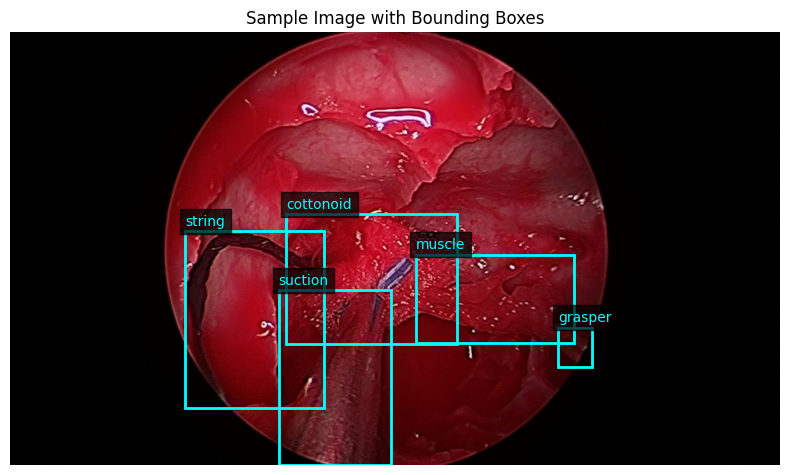

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Define class mapping
CLASS_MAPPING = {
    0: 'cottonoid',
    1: 'drill',
    2: 'grasper',
    3: 'muscle',
    4: 'scalpel',
    5: 'string',
    6: 'suction',
    7: 'tool'
}

def visualize_single_image_with_bounding_boxes(dataset):
    """
    Visualizes a single random image with bounding boxes and labels.

    :param dataset: PyTorch Dataset object
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    idx = random.randint(0, len(dataset) - 1)
    img, target = dataset[idx]

    # Convert image tensor to numpy
    img_np = img.permute(1, 2, 0).numpy()

    # Display the image
    ax.imshow(img_np)
    ax.axis('off')
    ax.set_title("Sample Image with Bounding Boxes")

    # Draw bounding boxes with labels
    for box, label in zip(target["boxes"], target["labels"]):
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin

        # Change bounding box and text color for better visibility
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='cyan', facecolor='none')
        ax.add_patch(rect)
        ax.text(
            xmin, ymin - 10, CLASS_MAPPING[label.item() - 1],
            color='cyan', fontsize=10, bbox=dict(facecolor='black', alpha=0.7)
        )

    plt.tight_layout()
    plt.show()

# Visualize a single random image from the train dataset
visualize_single_image_with_bounding_boxes(train_dataset)


In [ ]:
# Model and Optimizer
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=8 + 1)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 160MB/s]


In [ ]:
# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

Using device: cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Faster RCNN model Summary
summary(
    model,
    input_size=(1, 3, 512, 512),  # Batch size = 1, 3 channels, 512x512 resolution
    col_names=["input_size", "output_size", "num_params", "trainable"],  # Columns to display
    depth=3,  # Depth of layers to display in the summary
    device=device,
)


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
FasterRCNN                                              [1, 3, 512, 512]          [100, 4]                  --                        Partial
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 512, 512]          [1, 3, 800, 800]          --                        --
├─BackboneWithFPN: 1-2                                  [1, 3, 800, 800]          [1, 256, 13, 13]          --                        Partial
│    └─IntermediateLayerGetter: 2-1                     [1, 3, 800, 800]          [1, 2048, 25, 25]         --                        Partial
│    │    └─Conv2d: 3-1                                 [1, 3, 800, 800]          [1, 64, 400, 400]         (9,408)                   False
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 400, 400]         [1, 64, 400, 400]         --                        --
│    │    └─ReLU

Starting Epoch 1/10


Epoch 1/10 - Training: 100%|██████████| 240/240 [10:03<00:00,  2.52s/it]


Epoch 1 Training Loss: 0.8130


Evaluating: 100%|██████████| 240/240 [05:07<00:00,  1.28s/it]


Epoch 1 Training mAP: 0.2979


Epoch 1/10 - Validation: 100%|██████████| 55/55 [03:29<00:00,  3.81s/it]


Epoch 1 Validation Loss: 0.4998


Evaluating: 100%|██████████| 55/55 [00:30<00:00,  1.79it/s]


Epoch 1 Validation mAP: 0.3304


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best model saved with mAP: 0.3304
Precision: 0.2722, Recall: 0.3214, F1-Score: 0.2672, Accuracy: 0.3214
Starting Epoch 2/10


Epoch 2/10 - Training: 100%|██████████| 240/240 [04:49<00:00,  1.21s/it]


Epoch 2 Training Loss: 0.6511


Evaluating: 100%|██████████| 240/240 [02:58<00:00,  1.35it/s]


Epoch 2 Training mAP: 0.3858


Epoch 2/10 - Validation: 100%|██████████| 55/55 [00:57<00:00,  1.04s/it]


Epoch 2 Validation Loss: 0.4401


Evaluating: 100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


Epoch 2 Validation mAP: 0.4265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best model saved with mAP: 0.4265
Precision: 0.2590, Recall: 0.2883, F1-Score: 0.2660, Accuracy: 0.2883
Starting Epoch 3/10


Epoch 3/10 - Training: 100%|██████████| 240/240 [04:24<00:00,  1.10s/it]


Epoch 3 Training Loss: 0.5802


Evaluating: 100%|██████████| 240/240 [02:38<00:00,  1.51it/s]


Epoch 3 Training mAP: 0.5044


Epoch 3/10 - Validation: 100%|██████████| 55/55 [00:57<00:00,  1.04s/it]


Epoch 3 Validation Loss: 0.3894


Evaluating: 100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Epoch 3 Validation mAP: 0.5388
Best model saved with mAP: 0.5388
Precision: 0.2846, Recall: 0.2890, F1-Score: 0.2742, Accuracy: 0.2890
Starting Epoch 4/10


Epoch 4/10 - Training: 100%|██████████| 240/240 [04:21<00:00,  1.09s/it]


Epoch 4 Training Loss: 0.5323


Evaluating: 100%|██████████| 240/240 [02:39<00:00,  1.50it/s]


Epoch 4 Training mAP: 0.5690


Epoch 4/10 - Validation: 100%|██████████| 55/55 [00:57<00:00,  1.05s/it]


Epoch 4 Validation Loss: 0.3599


Evaluating: 100%|██████████| 55/55 [00:31<00:00,  1.73it/s]


Epoch 4 Validation mAP: 0.5873
Best model saved with mAP: 0.5873
Precision: 0.3190, Recall: 0.3122, F1-Score: 0.3089, Accuracy: 0.3122
Starting Epoch 5/10


Epoch 5/10 - Training: 100%|██████████| 240/240 [04:21<00:00,  1.09s/it]


Epoch 5 Training Loss: 0.4779


Evaluating: 100%|██████████| 240/240 [02:38<00:00,  1.51it/s]


Epoch 5 Training mAP: 0.5899


Epoch 5/10 - Validation: 100%|██████████| 55/55 [00:57<00:00,  1.04s/it]


Epoch 5 Validation Loss: 0.3527


Evaluating: 100%|██████████| 55/55 [00:31<00:00,  1.75it/s]


Epoch 5 Validation mAP: 0.6031
Best model saved with mAP: 0.6031
Precision: 0.3084, Recall: 0.3071, F1-Score: 0.3035, Accuracy: 0.3071
Starting Epoch 6/10


Epoch 6/10 - Training: 100%|██████████| 240/240 [04:21<00:00,  1.09s/it]


Epoch 6 Training Loss: 0.5091


Evaluating: 100%|██████████| 240/240 [02:37<00:00,  1.52it/s]


Epoch 6 Training mAP: 0.6015


Epoch 6/10 - Validation: 100%|██████████| 55/55 [00:57<00:00,  1.05s/it]


Epoch 6 Validation Loss: 0.3514


Evaluating: 100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


Epoch 6 Validation mAP: 0.6258
Best model saved with mAP: 0.6258
Precision: 0.3287, Recall: 0.3290, F1-Score: 0.3240, Accuracy: 0.3290
Starting Epoch 7/10


Epoch 7/10 - Training: 100%|██████████| 240/240 [04:21<00:00,  1.09s/it]


Epoch 7 Training Loss: 0.4996


Evaluating: 100%|██████████| 240/240 [02:37<00:00,  1.52it/s]


Epoch 7 Training mAP: 0.5857


Epoch 7/10 - Validation: 100%|██████████| 55/55 [00:57<00:00,  1.05s/it]


Epoch 7 Validation Loss: 0.3463


Evaluating: 100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


Epoch 7 Validation mAP: 0.6183
Precision: 0.3170, Recall: 0.3188, F1-Score: 0.3149, Accuracy: 0.3188
Starting Epoch 8/10


Epoch 8/10 - Training: 100%|██████████| 240/240 [04:21<00:00,  1.09s/it]


Epoch 8 Training Loss: 0.4904


Evaluating: 100%|██████████| 240/240 [02:39<00:00,  1.51it/s]


Epoch 8 Training mAP: 0.6185


Epoch 8/10 - Validation: 100%|██████████| 55/55 [00:57<00:00,  1.05s/it]


Epoch 8 Validation Loss: 0.3487


Evaluating: 100%|██████████| 55/55 [00:31<00:00,  1.75it/s]


Epoch 8 Validation mAP: 0.6182
Precision: 0.3207, Recall: 0.3178, F1-Score: 0.3158, Accuracy: 0.3178
Starting Epoch 9/10


Epoch 9/10 - Training: 100%|██████████| 240/240 [04:20<00:00,  1.09s/it]


Epoch 9 Training Loss: 0.4701


Evaluating: 100%|██████████| 240/240 [02:37<00:00,  1.52it/s]


Epoch 9 Training mAP: 0.6171


Epoch 9/10 - Validation: 100%|██████████| 55/55 [00:57<00:00,  1.05s/it]


Epoch 9 Validation Loss: 0.3475


Evaluating: 100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


Epoch 9 Validation mAP: 0.6051
Precision: 0.3220, Recall: 0.3189, F1-Score: 0.3175, Accuracy: 0.3189
Starting Epoch 10/10


Epoch 10/10 - Training: 100%|██████████| 240/240 [04:21<00:00,  1.09s/it]


Epoch 10 Training Loss: 0.4802


Evaluating: 100%|██████████| 240/240 [02:37<00:00,  1.52it/s]


Epoch 10 Training mAP: 0.6059


Epoch 10/10 - Validation: 100%|██████████| 55/55 [00:57<00:00,  1.05s/it]


Epoch 10 Validation Loss: 0.3488


Evaluating: 100%|██████████| 55/55 [00:31<00:00,  1.74it/s]


Epoch 10 Validation mAP: 0.6049
Precision: 0.3192, Recall: 0.3162, F1-Score: 0.3150, Accuracy: 0.3162


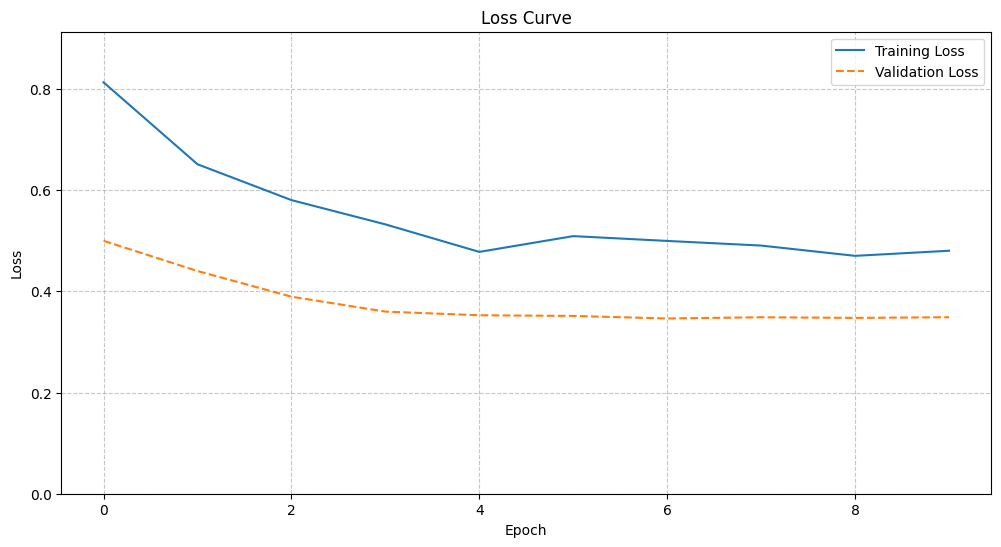

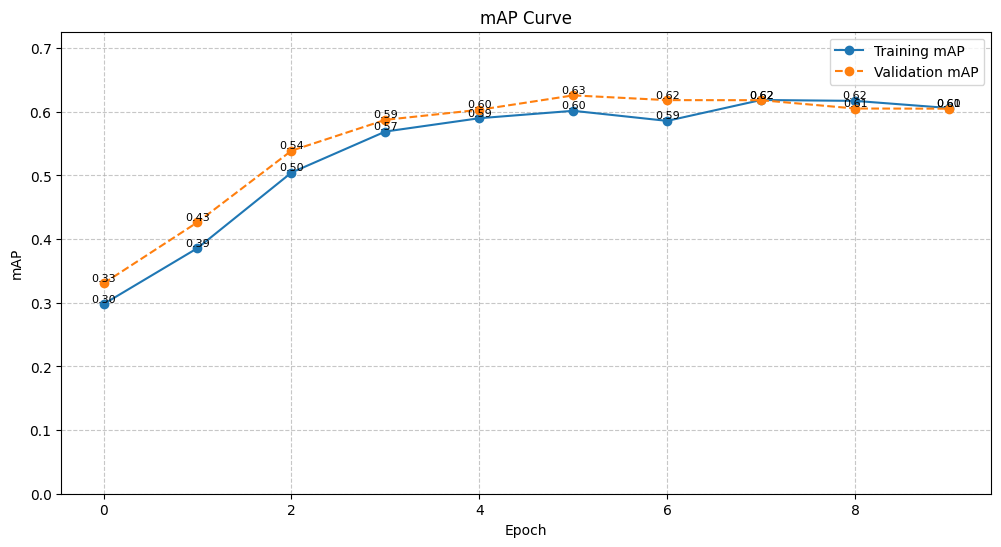

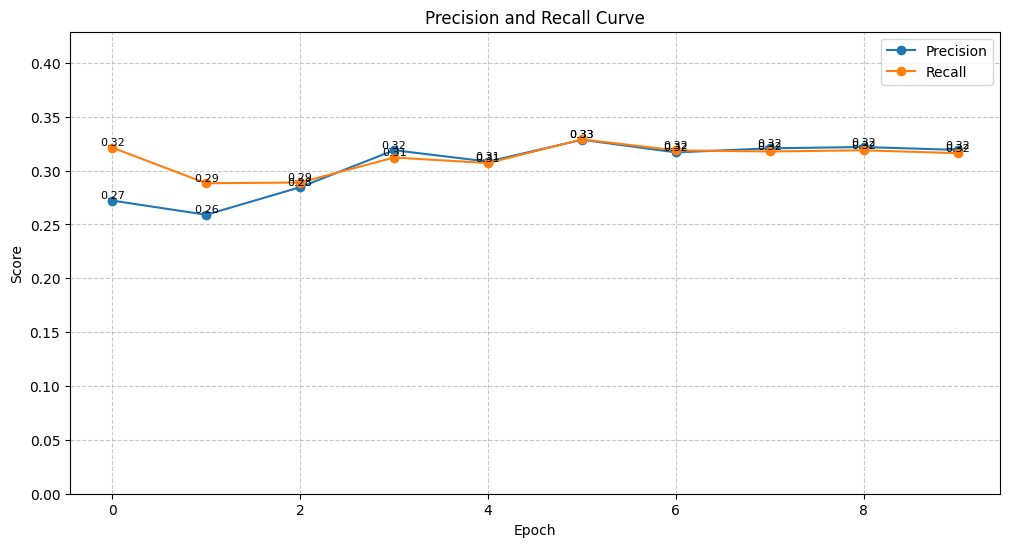

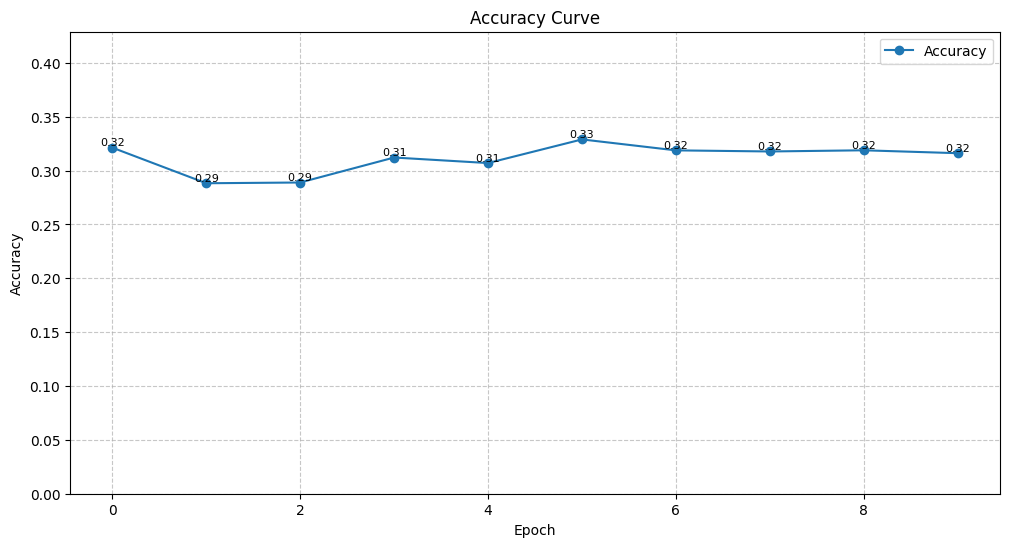

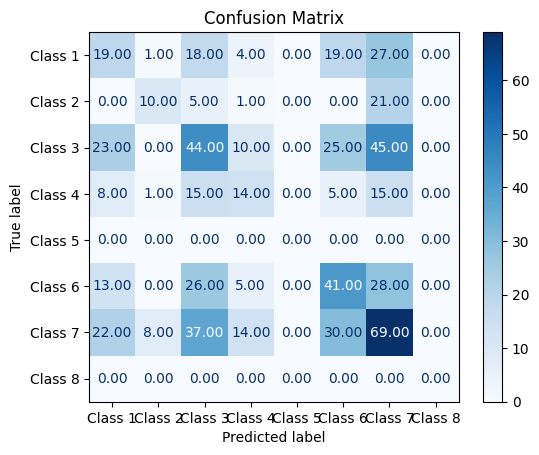


Final F1-Score: 0.3150

Final Classification Report:
              precision    recall  f1-score   support

           1       0.22      0.22      0.22        88
           2       0.50      0.27      0.35        37
           3       0.30      0.30      0.30       147
           4       0.29      0.24      0.26        58
           6       0.34      0.36      0.35       113
           7       0.34      0.38      0.36       180

    accuracy                           0.32       623
   macro avg       0.33      0.30      0.31       623
weighted avg       0.32      0.32      0.31       623


Training Complete.


In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="./logs")

train_model_with_logging_and_metrics(
    model, optimizer, train_loader, val_loader, device,
    scheduler=scheduler, epochs=10, eval_interval=1, writer=writer, model_save_path="best_model.pth"
)

writer.close()


In [ ]:
CLASS_MAPPING = {
    0: 'cottonoid',
    1: 'drill',
    2: 'grasper',
    3: 'muscle',
    4: 'scalpel',
    5: 'string',
    6: 'suction',
    7: 'tool'
}


In [ ]:
def visualize_ground_truth_and_predictions(
    dataset, model, class_mapping, device, num_samples=5, score_threshold=0.5
):
    model.eval()
    for i in range(num_samples):
        # Get ground truth data
        img, target = dataset[i]
        img = img.to(device)

        with torch.no_grad():
            # Get model predictions
            prediction = model([img])[0]

        # Convert image to NumPy for visualization
        img_np = img.permute(1, 2, 0).cpu().numpy()

        # Extract ground truth boxes and labels
        gt_boxes = target["boxes"].cpu().numpy()
        gt_labels = target["labels"].cpu().numpy()

        # Extract prediction boxes, labels, and scores
        pred_boxes = prediction["boxes"].cpu().numpy()
        pred_labels = prediction["labels"].cpu().numpy()
        pred_scores = prediction["scores"].cpu().numpy()

        # Apply threshold to predictions
        filtered_indices = pred_scores > score_threshold
        pred_boxes = pred_boxes[filtered_indices]
        pred_labels = pred_labels[filtered_indices]
        pred_scores = pred_scores[filtered_indices]

        # Plot the image
        plt.figure(figsize=(12, 8))
        plt.imshow(img_np)

        # Plot ground truth boxes (in green)
        for box, label in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = box
            class_name = class_mapping.get(label, f"Unknown ({label})")
            plt.gca().add_patch(
                plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="green", linewidth=2)
            )
            plt.text(x1, y1 - 10, f"GT: {class_name}", color="green", fontsize=12)

        # Plot prediction boxes (in red) with threshold
        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            x1, y1, x2, y2 = box
            class_name = class_mapping.get(label, f"Unknown ({label})")
            plt.gca().add_patch(
                plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="red", linewidth=2)
            )
            plt.text(
                x1, y1 - 30, f"Pred: {class_name} ({score:.2f})",
                color="red", fontsize=12, backgroundcolor="white"
            )

        plt.axis("off")
        plt.show()


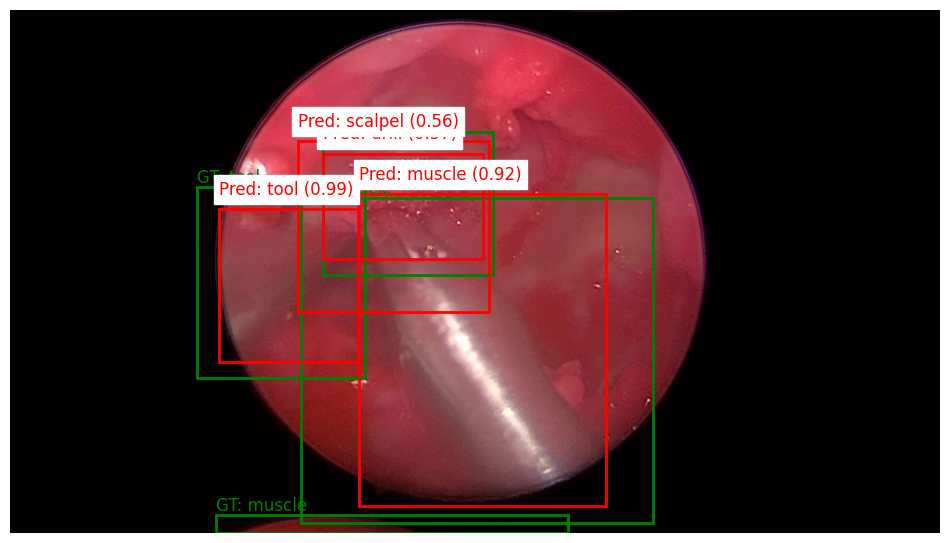

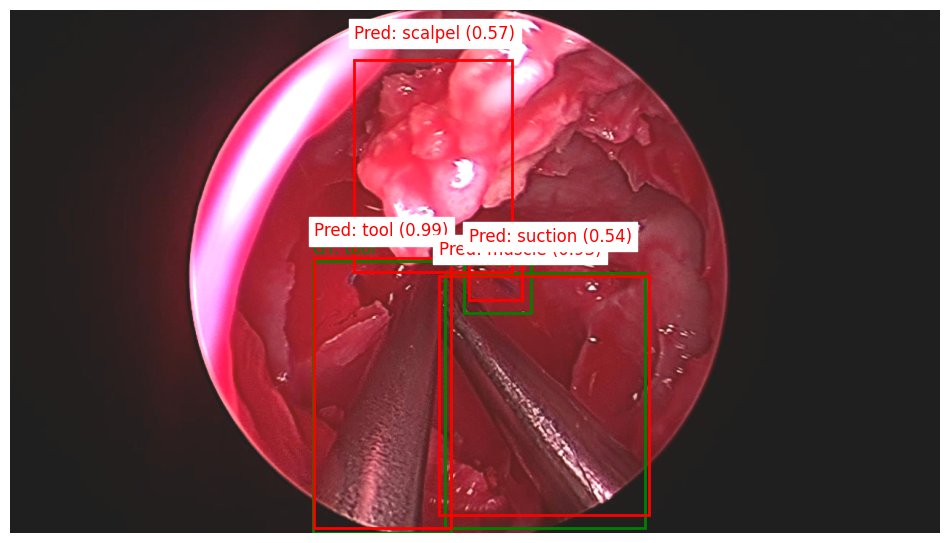

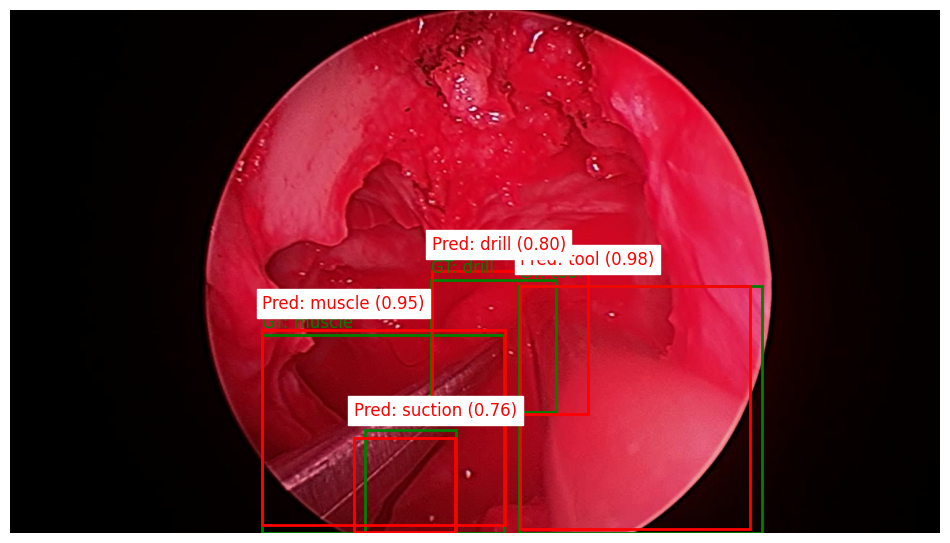

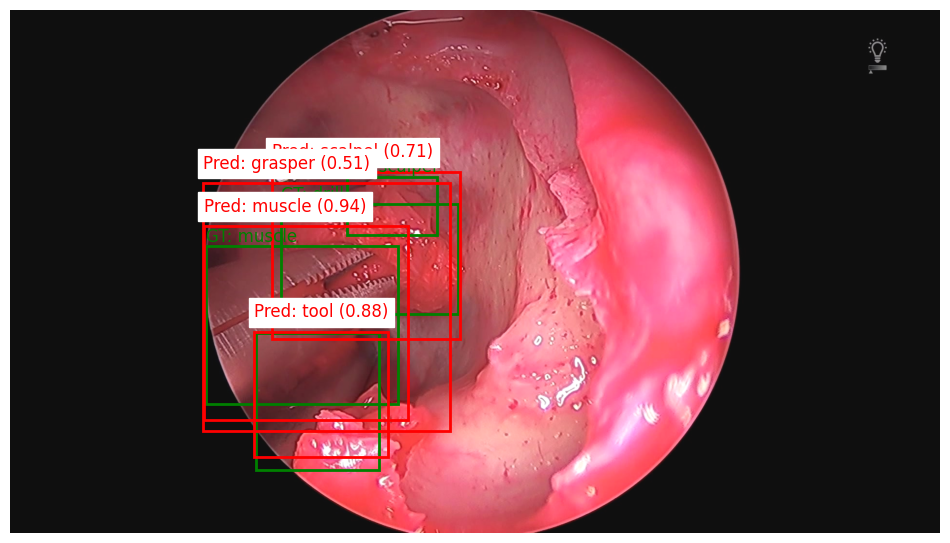

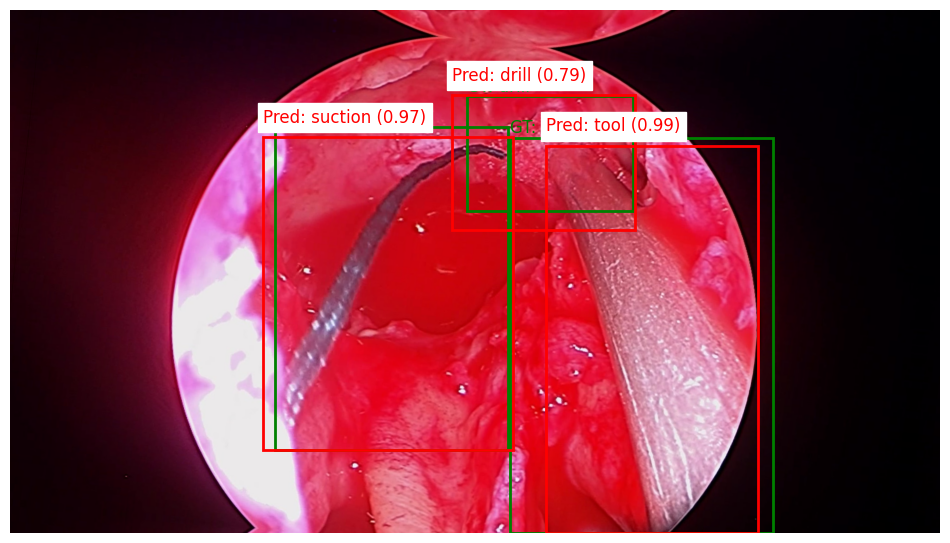

In [ ]:
# Define the class mapping
CLASS_MAPPING = {
    0: 'cottonoid',
    1: 'drill',
    2: 'grasper',
    3: 'muscle',
    4: 'scalpel',
    5: 'string',
    6: 'suction',
    7: 'tool'
}

visualize_ground_truth_and_predictions(
    train_dataset, model, CLASS_MAPPING, device, num_samples=5, score_threshold=0.5
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-21-3e3cfb6f938a>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

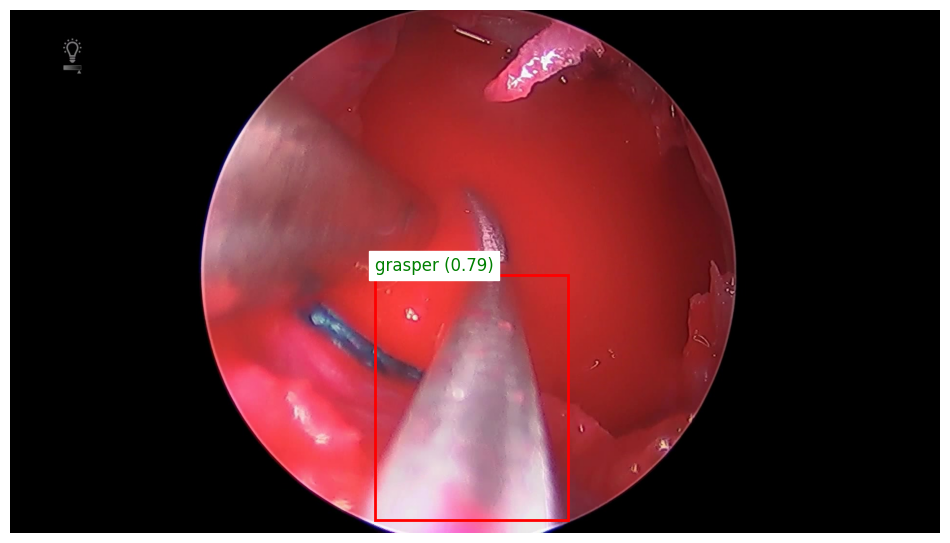

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define class mapping
CLASS_MAPPING = {
    0: 'cottonoid',
    1: 'drill',
    2: 'grasper',
    3: 'muscle',
    4: 'scalpel',
    5: 'string',
    6: 'suction',
    7: 'tool'
}

# Load the model
def load_model(weight_path, num_classes=8):
    # Create the base model
    model = fasterrcnn_resnet50_fpn(pretrained=False)

    # Update the box predictor with the correct number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes + 1)  # +1 for background

    # Load the state_dict
    state_dict = torch.load(weight_path, map_location=torch.device("cpu"))
    model.load_state_dict(state_dict)
    model.eval()
    return model


# Load your trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model("/content/fasterrcnn_surgical_tools (1).pth", num_classes=8).to(device)

# Predict on a single image
def predict_on_image(image_path, model, class_mapping, device, score_threshold=0.5):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
    img_tensor = img_tensor.to(device)

    with torch.no_grad():
        prediction = model(img_tensor)[0]

    # Filter predictions by score threshold
    boxes = prediction["boxes"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()

    filtered_indices = scores > score_threshold
    boxes = boxes[filtered_indices]
    labels = labels[filtered_indices]
    scores = scores[filtered_indices]

    # Visualize predictions
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        class_name = class_mapping.get(label, f"Unknown ({label})")
        plt.gca().add_patch(
            plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="red", linewidth=2)
        )
        plt.text(
            x1, y1 - 10, f"{class_name} ({score:.2f})", color="green", fontsize=12, backgroundcolor="white"
        )
    plt.axis("off")
    plt.show()

# Predict on a video
def predict_on_video(video_path, model, class_mapping, device, score_threshold=0.5, output_path=None):
    cap = cv2.VideoCapture(video_path)
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(output_path, fourcc, cap.get(cv2.CAP_PROP_FPS),
                              (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to tensor
        img_tensor = torch.tensor(frame, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
        img_tensor = img_tensor.to(device)

        # Perform inference
        with torch.no_grad():
            prediction = model(img_tensor)[0]

        # Filter predictions by score threshold
        boxes = prediction["boxes"].cpu().numpy()
        labels = prediction["labels"].cpu().numpy()
        scores = prediction["scores"].cpu().numpy()

        filtered_indices = scores > score_threshold
        boxes = boxes[filtered_indices]
        labels = labels[filtered_indices]
        scores = scores[filtered_indices]

        # Overlay predictions on the frame
        for box, label, score in zip(boxes, labels, scores):
            x1, y1, x2, y2 = map(int, box)
            class_name = class_mapping.get(label, f"Unknown ({label})")
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"{class_name} ({score:.2f})", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Show frame
        cv2.imshow("Predictions", frame)
        if output_path:
            out.write(frame)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release()
    if output_path:
        out.release()
    cv2.destroyAllWindows()

# Predict on a webcam
def predict_on_webcam(model, class_mapping, device, score_threshold=0.5):
    cap = cv2.VideoCapture(0)  # 0 for default webcam
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to tensor
        img_tensor = torch.tensor(frame, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
        img_tensor = img_tensor.to(device)

        # Perform inference
        with torch.no_grad():
            prediction = model(img_tensor)[0]

        # Filter predictions by score threshold
        boxes = prediction["boxes"].cpu().numpy()
        labels = prediction["labels"].cpu().numpy()
        scores = prediction["scores"].cpu().numpy()

        filtered_indices = scores > score_threshold
        boxes = boxes[filtered_indices]
        labels = labels[filtered_indices]
        scores = scores[filtered_indices]

        # Overlay predictions on the frame
        for box, label, score in zip(boxes, labels, scores):
            x1, y1, x2, y2 = map(int, box)
            class_name = class_mapping.get(label, f"Unknown ({label})")
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"{class_name} ({score:.2f})", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Show frame
        cv2.imshow("Predictions", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
# Predict on an image
predict_on_image("/content/drive/MyDrive/data/images/train/S102T1_frame_00000176.jpeg", model, CLASS_MAPPING, device, score_threshold=0.5)

# Predict on a video
#predict_on_video("path/to/video.mp4", model, CLASS_MAPPING, device, score_threshold=0.5, output_path="output.mp4")

# Predict using webcam
#predict_on_webcam(model, CLASS_MAPPING, device, score_threshold=0.5)
